In [ ]:
#Import libraries for different Graph Neural Network

import numpy as np
import pandas as pd
import os

import torch

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric
from torch.nn import Parameter
from torch_geometric.utils.convert import to_networkx
import networkx as nx
import urllib.request
import tarfile
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
# from torch_geometric.nn import NeighborSampler
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx


In [ ]:
# Load the PubMMed dataset
dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

In [ ]:
# view the dataset details
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

In [ ]:
# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

In [ ]:
# #Visualize the graph using networkx
plt.figure(figsize=(10, 10))
pubmed = torch_geometric.data.Data(x=data.x[:500], edge_index=data.edge_index[:500])
g = torch_geometric.utils.to_networkx(pubmed, to_undirected=True)
pubmedGraph = g
node_labels = data.y[list(pubmedGraph.nodes)].numpy()
nx.draw(g, cmap=plt.get_cmap('Set1'),node_color = node_labels,node_size=75,linewidths=6)

In [ ]:
#set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.optim as optim

train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

'''
Graph Convolutional Network
GCN takes graphs as an input and applies convolution operations over the graph
'''
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)
    def forward(self, x, edge_index):
        # x: Node feature matrix
        # edge_index: Graph connectivity matrix
        #x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x, F.log_softmax(x, dim=1)
'''
Graph SAGE: SAmpling and aggreGatE,
Samples only a subset of neighboring nodes at different depth layers,
and then the aggregator takes neighbors of the previous layers and aggregates them
'''
class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h*2)
    self.sage2 = SAGEConv(dim_h*2, dim_h)
    self.sage3 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.2, training=self.training)
    h = self.sage3(h, edge_index)
    return h, F.log_softmax(h, dim=1)
'''
GAT- uses Attention stratgey
compute the hidden representations of each node in the Graph by attending
over its neighbors using a self-attention strategy
'''
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1

        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)

    def forward(self,x, edge_index):

        # Dropout before the GAT layer is used to avoid overfitting
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x,F.log_softmax(x, dim=1)


In [ ]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer

    model.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()

        _, out = model(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1),
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1),
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {total_loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [ ]:
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes).to(device)
print(graphsage)

# Train GraphSAGE
train(graphsage, dataset, 200)

# Test GraphSAGE
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

# Create GAT
gat = GAT().to(device)
print(gat)

# Train Graph Attention Network
train(gat, dataset, 200)

# Test GAT
print(f'\nGraph Attention Network test accuracy: {test(gat, data)*100:.2f}%\n')

# Create GCN
gcn = GCN().to(device)
print(gcn)

# Train GCN
train(gcn, dataset, 200)

# Test GCN
print(f'\nGCN test accuracy: {test(gat, data)*100:.2f}%\n')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphSAGE, GATConv, GCNConv
from torch_geometric.data import DataLoader
from torch_geometric.datasets import Planetoid

# Load a dataset (e.g., Planetoid dataset)
dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Define GraphSAGE model
class CustomGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(CustomGraphSAGE, self).__init__()
        self.conv1 = GraphSAGE(in_channels, hidden_channels, num_layers=2)
        self.conv2 = GraphSAGE(hidden_channels, out_channels, num_layers=2)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return F.log_softmax(x, dim=1)

# Define GAT model
class CustomGAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomGAT, self).__init__()
        self.conv1 = GATConv(in_channels, out_channels, heads=8, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        return F.log_softmax(x, dim=1)

# Define GCN model
class CustomGCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return F.log_softmax(x, dim=1)

# Training loop using DataLoader
def train(model, loader, optimizer, device, epochs):
    model.train()

    for epoch in range(epochs):
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# Test function
def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.num_nodes

    accuracy = correct / total
    return accuracy

# Instantiate GraphSAGE, GAT, and GCN models
graphsage = CustomGraphSAGE(dataset.num_features, 64, dataset.num_classes).to(device)
gat = CustomGAT(dataset.num_features, 64).to(device)
gcn = CustomGCN(dataset.num_features, 64).to(device)

# Optionally move the models to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graphsage = graphsage.to(device)
gat = gat.to(device)
gcn = gcn.to(device)

# Dummy DataLoader (replace this with your actual DataLoader)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Dummy optimizer (replace this with your actual optimizer)
optimizer_graphsage = torch.optim.Adam(graphsage.parameters(), lr=0.01)
optimizer_gat = torch.optim.Adam(gat.parameters(), lr=0.01)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01)

# Train and test models
train(graphsage, loader, optimizer_graphsage, device, epochs=200)
train(gat, loader, optimizer_gat, device, epochs=200)
train(gcn, loader, optimizer_gcn, device, epochs=200)

accuracy_graphsage = test(graphsage, loader, device)
accuracy_gat = test(gat, loader, device)
accuracy_gcn = test(gcn, loader, device)

print(f'GraphSAGE test accuracy: {accuracy_graphsage * 100:.2f}%')
print(f'GAT test accuracy: {accuracy_gat * 100:.2f}%')
print(f'GCN test accuracy: {accuracy_gcn * 100:.2f}%')


In [3]:
#Import libraries for different Graph Neural Network

import numpy as np
import pandas as pd
import os
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric
from torch.nn import Parameter
from torch_geometric.utils.convert import to_networkx
import networkx as nx
import urllib.request
import tarfile
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Load the PubMMed dataset
dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]


# view the dataset details
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')


#set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create batches with neighbor sampling
#A NeighborLoader is a data loader that performs neighbor sampling for GNN's
#Allows for mini-batch training of GNNs on large-scale graphs where full-batch training is not feasible.
#num_neighbors denotes how many neighbors are sampled for each node in each iteration.
#https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

'''
Graph Convolutional Network
GCN takes graphs as an input and applies convolution operations over the graph
'''
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)
    def forward(self, x, edge_index):
        # x: Node feature matrix 
        # edge_index: Graph connectivity matrix 
        #x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x, F.log_softmax(x, dim=1)
'''
Graph SAGE: SAmpling and aggreGatE, 
Samples only a subset of neighboring nodes at different depth layers, 
and then the aggregator takes neighbors of the previous layers and aggregates them
'''
class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h*2)
    self.sage2 = SAGEConv(dim_h*2, dim_h)
    self.sage3 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.2, training=self.training)
    h = self.sage3(h, edge_index)
    return h, F.log_softmax(h, dim=1)
'''
GAT- uses Attention stratgey
compute the hidden representations of each node in the Graph by attending 
over its neighbors using a self-attention strategy
'''
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)

    def forward(self,x, edge_index):
        
        # Dropout before the GAT layer is used to avoid overfitting
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x,F.log_softmax(x, dim=1)


def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer

    model.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        
        _, out = model(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1), 
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1), 
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {total_loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')
          
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes).to(device)
print(graphsage)

# Train GraphSAGE
train(graphsage, dataset, 200)

# Test GraphSAGE
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

# Create GAT
gat = GAT().to(device)
print(gat)

# Train Graph Attention Network
train(gat, dataset, 200)

# Test GAT
print(f'\nGraph Attention Network test accuracy: {test(gat, data)*100:.2f}%\n')

# Create GCN
gcn = GCN().to(device)
print(gcn)

# Train GCN
train(gcn, dataset, 200)

# Test GCN
print(f'\nGCN test accuracy: {test(gat, data)*100:.2f}%\n')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False
GraphSAGE(
  (sage1): SAGEConv(500, 128, aggr=mean)
  (sage2): SAGEConv(128, 64, aggr=mean)
  (sage3): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 1.177 | Train Acc:  29.04% | Val Loss: 1.11 | Val Acc: 32.44%
Epoch  10 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 0.68 | Val Acc: 77.37%
Epoch  20 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 0.94 | Val Acc: 54.12%
Epoch  30 | Train Loss: 0.057 | Train Acc:  98.44% | Val Loss: 0.67 | Val Acc: 78.89%
Epoch  40 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 71.43%
Epoch  50 | Train Loss: 0.013 | Train Acc: 100.00% | Val Loss: 0.70 | Val Acc: 72.50%
Epoch  60 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 0.66 | Va

In [4]:
# Test GraphSAGE
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')
# Test GCN
print(f'\nGCN test accuracy: {test(gat, data)*100:.2f}%\n')
# Test GAT
print(f'\nGraph Attention Network test accuracy: {test(gat, data)*100:.2f}%\n')


GraphSAGE test accuracy: 76.60%


GCN test accuracy: 72.90%


Graph Attention Network test accuracy: 72.90%



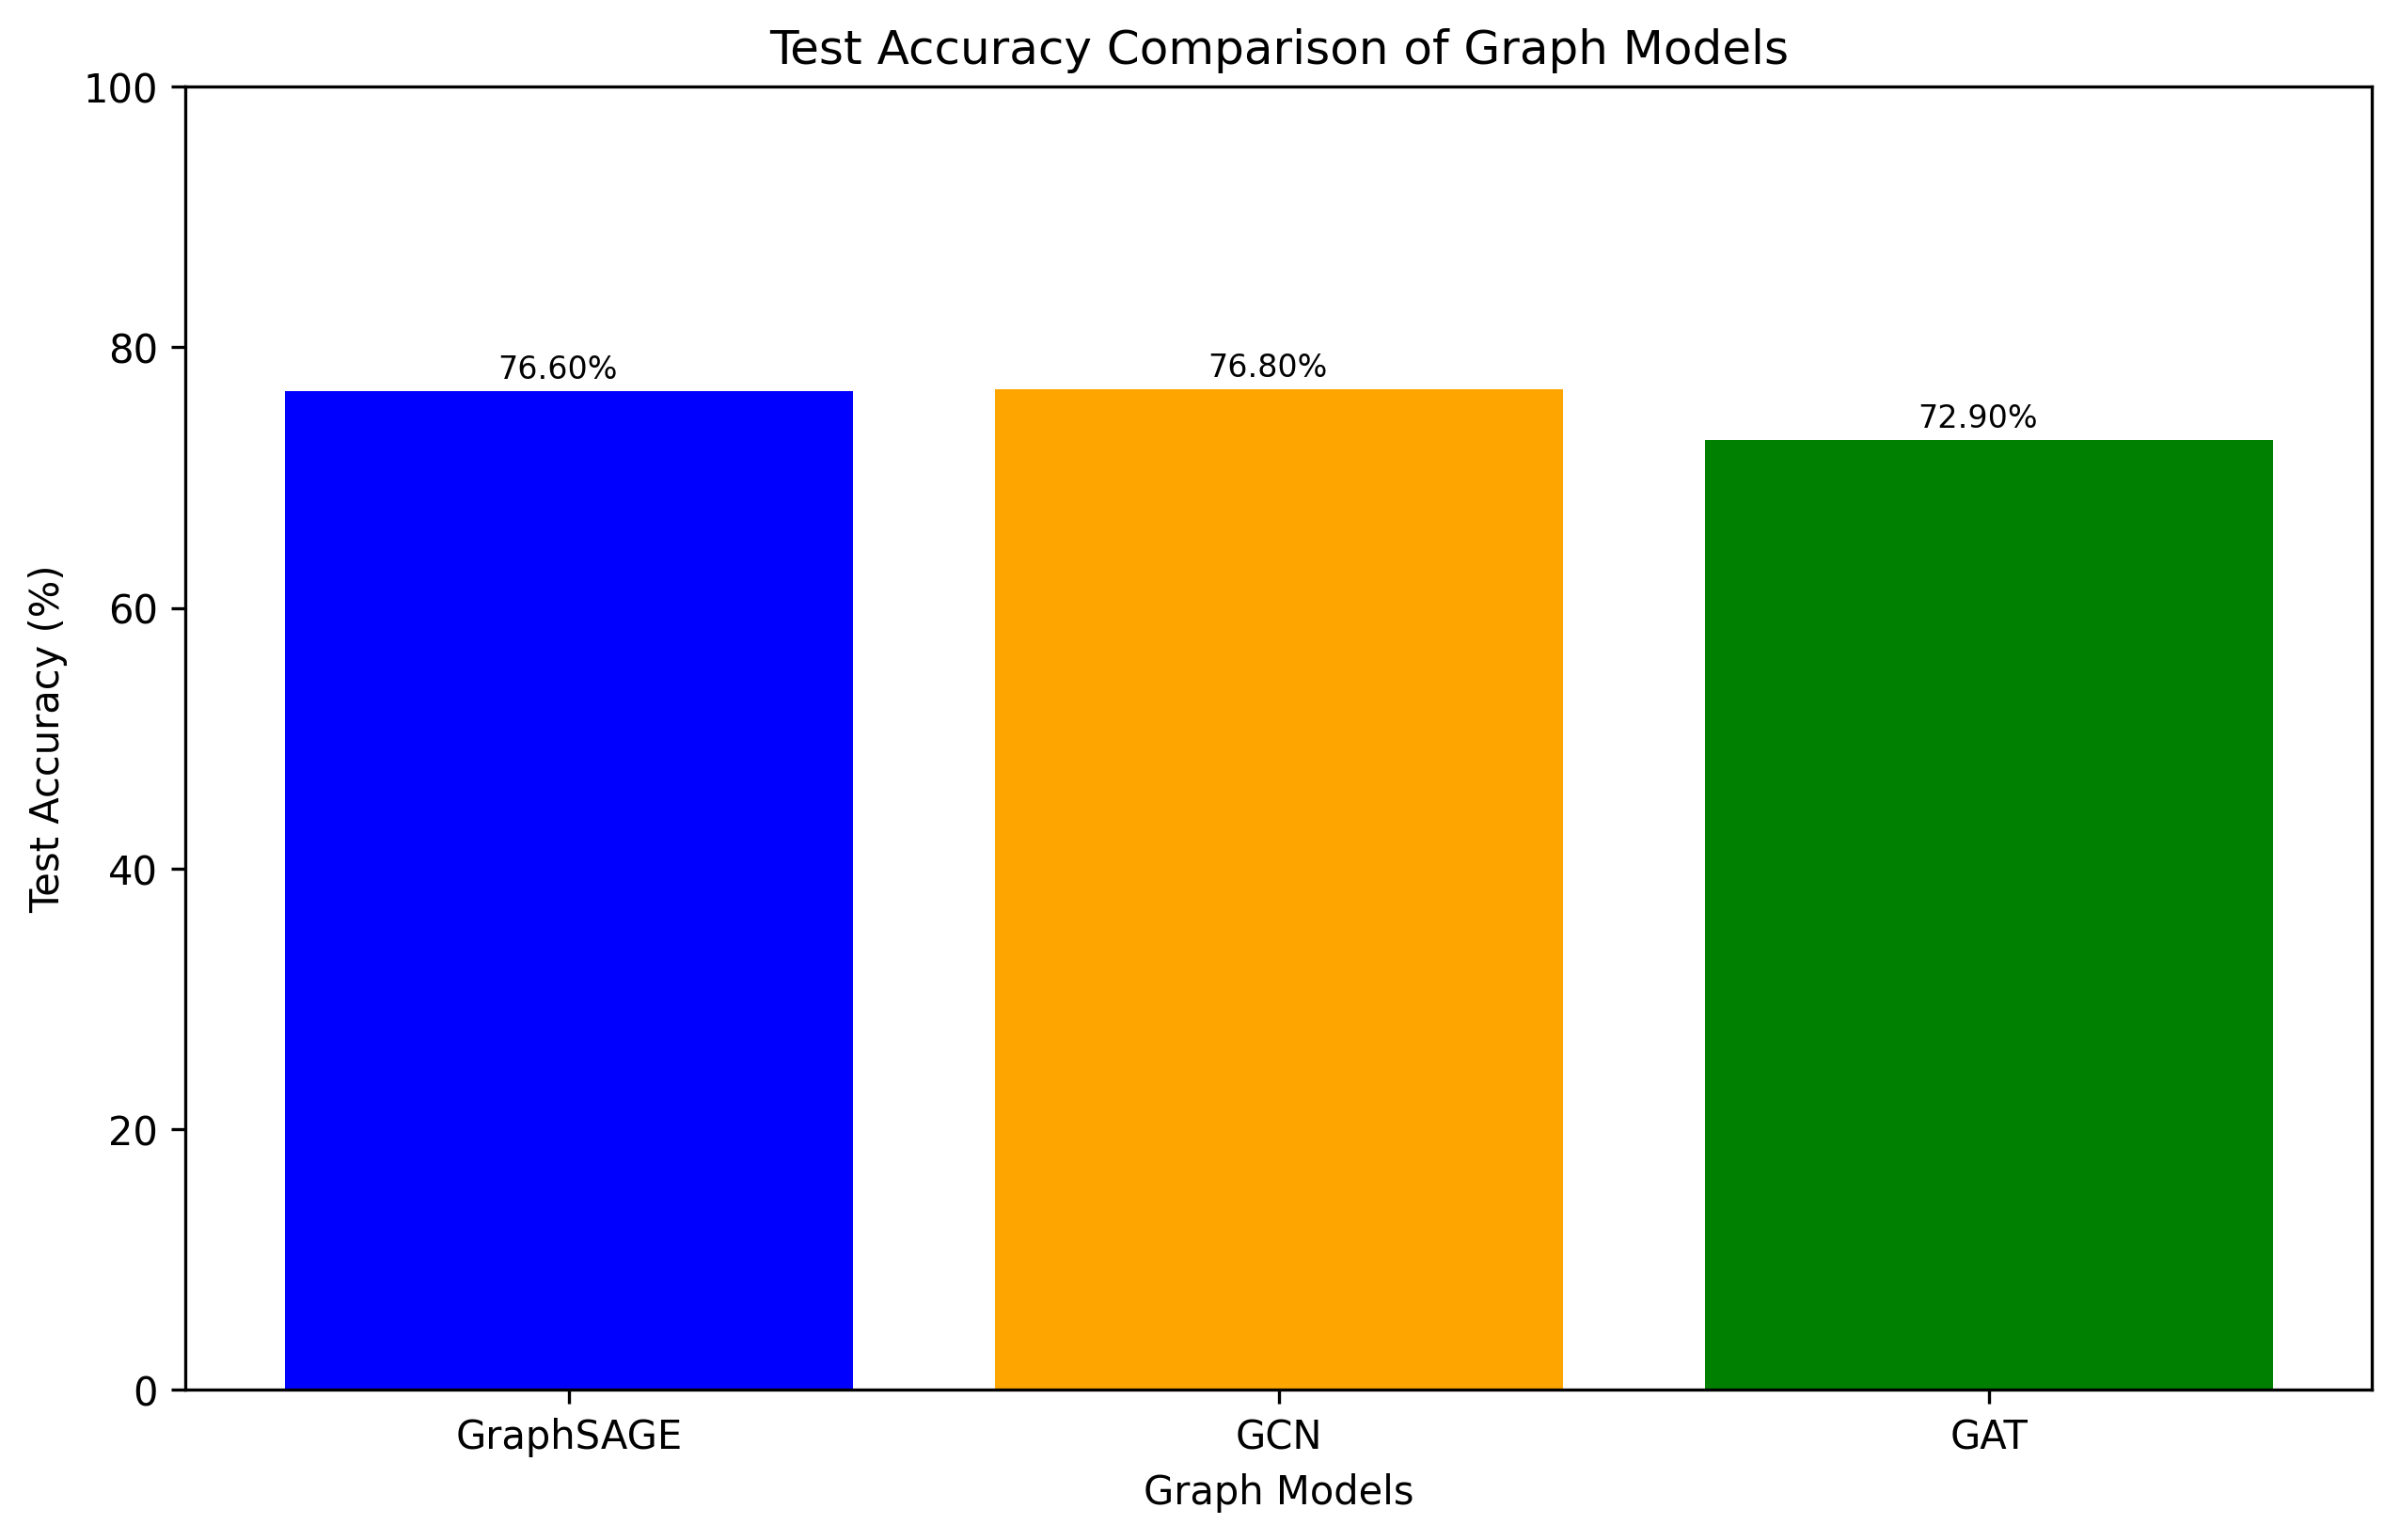

In [6]:
import matplotlib.pyplot as plt

# Assuming you have the following test results
graphsage_accuracy = test(graphsage, data) * 100
gcn_accuracy = test(gcn, data) * 100
gat_accuracy = test(gat, data) * 100

# Plotting the bar graph
models = ['GraphSAGE', 'GCN', 'GAT']
accuracies = [graphsage_accuracy, gcn_accuracy, gat_accuracy]

plt.figure(figsize=(10, 6), dpi=300)  # Adjust the size and dpi for high resolution

bars = plt.bar(models, accuracies, color=['blue', 'orange', 'green'])

# Adding percentages on top of the bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 1, f'{accuracy:.2f}%', fontsize=8)

plt.xlabel('Graph Models')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison of Graph Models')
plt.ylim(0, 100)  # Set the y-axis limit to ensure proper visualization of percentages
plt.show()



GCN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 3)
)
Epoch   0 | Train Loss: 1.103 | Train Acc:  28.58% | Val Loss: 1.08 | Val Acc: 53.33%
Epoch  10 | Train Loss: 0.779 | Train Acc:  93.32% | Val Loss: 0.81 | Val Acc: 78.27%
Epoch  20 | Train Loss: 0.507 | Train Acc:  92.89% | Val Loss: 0.60 | Val Acc: 72.08%
Epoch  30 | Train Loss: 0.328 | Train Acc:  96.35% | Val Loss: 0.63 | Val Acc: 72.92%
Epoch  40 | Train Loss: 0.259 | Train Acc:  94.79% | Val Loss: 0.49 | Val Acc: 78.54%
Epoch  50 | Train Loss: 0.180 | Train Acc: 100.00% | Val Loss: 0.55 | Val Acc: 71.12%
Epoch  60 | Train Loss: 0.176 | Train Acc:  98.08% | Val Loss: 0.29 | Val Acc: 91.15%
Epoch  70 | Train Loss: 0.134 | Train Acc:  98.53% | Val Loss: 0.64 | Val Acc: 69.01%
Epoch  80 | Train Loss: 0.094 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 62.78%
Epoch  90 | Train Loss: 0.104 | Train Acc: 100.00% | Val Loss: 0.46 | Val Acc: 84.90%
Epoch 100 | Train Loss: 0.110 | Train Acc:  98.44% | Val Loss: 0.20 | Val Acc: 

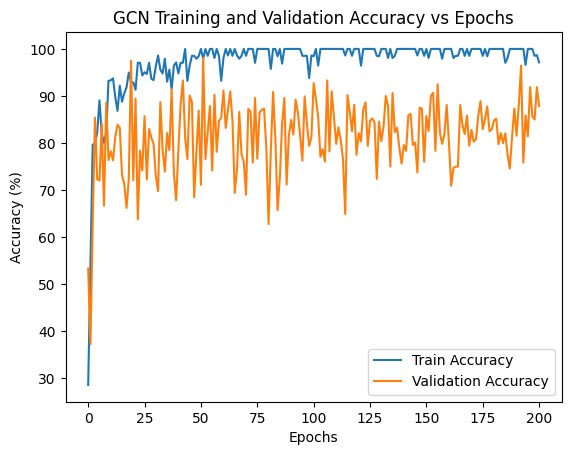

In [8]:
import matplotlib.pyplot as plt

# ... (previous code remains unchanged)

def train(model, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer

    model.train()
    
    train_accuracies = []  # Store training accuracies
    val_accuracies = []    # Store validation accuracies

    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for batch in train_loader:
            optimizer.zero_grad()
            
            _, out = model(batch.x, batch.edge_index)
            loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
            total_loss += loss
            acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
            loss.backward()
            optimizer.step()

            # Validation
            val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
            val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

        # Calculate and store training and validation accuracies
        train_accuracies.append(acc/len(train_loader)*100)
        val_accuracies.append(val_acc/len(train_loader)*100)

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss/len(train_loader):.3f} '
                  f'| Train Acc: {train_accuracies[-1]:>6.2f}% | Val Loss: '
                  f'{val_loss/len(train_loader):.2f} | Val Acc: '
                  f'{val_accuracies[-1]:.2f}%')
    
    # Plotting
    plt.plot(range(epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('GCN Training and Validation Accuracy vs Epochs')
    plt.legend()
    plt.show()

# Create GCN
gcn = GCN().to(device)
print(gcn)

# Train GCN
train(gcn, dataset, 200)




GraphSAGE(
  (sage1): SAGEConv(500, 128, aggr=mean)
  (sage2): SAGEConv(128, 64, aggr=mean)
  (sage3): SAGEConv(64, 3, aggr=mean)
)
GraphSAGE - Epoch   0 | Train Loss: 1.232 | Train Acc:  30.24% | Val Loss: 1.17 | Val Acc: 21.43%
GraphSAGE - Epoch  10 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 0.51 | Val Acc: 77.92%
GraphSAGE - Epoch  20 | Train Loss: 0.013 | Train Acc: 100.00% | Val Loss: 0.55 | Val Acc: 83.89%
GraphSAGE - Epoch  30 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 80.34%
GraphSAGE - Epoch  40 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 0.49 | Val Acc: 81.19%
GraphSAGE - Epoch  50 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 0.50 | Val Acc: 78.89%
GraphSAGE - Epoch  60 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 0.48 | Val Acc: 76.25%
GraphSAGE - Epoch  70 | Train Loss: 0.016 | Train Acc:  98.53% | Val Loss: 0.44 | Val Acc: 91.73%
GraphSAGE - Epoch  80 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 0.43 | Va

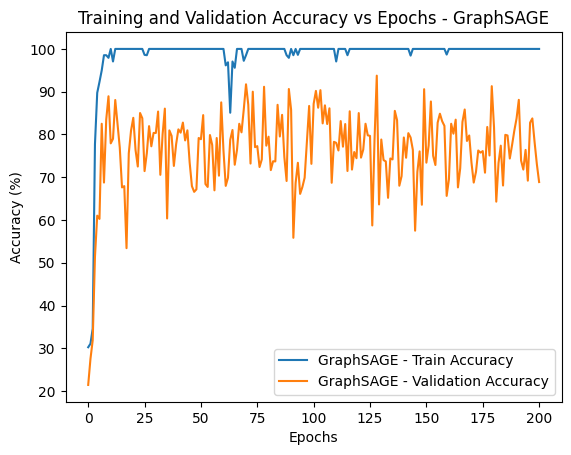

GAT(
  (conv1): GATConv(500, 8, heads=8)
  (conv2): GATConv(64, 3, heads=1)
)
Graph Attention Network - Epoch   0 | Train Loss: 1.121 | Train Acc:  22.64% | Val Loss: 1.18 | Val Acc: 18.06%
Graph Attention Network - Epoch  10 | Train Loss: 0.875 | Train Acc:  73.81% | Val Loss: 0.86 | Val Acc: 52.50%
Graph Attention Network - Epoch  20 | Train Loss: 0.649 | Train Acc:  76.35% | Val Loss: 0.80 | Val Acc: 64.38%
Graph Attention Network - Epoch  30 | Train Loss: 0.448 | Train Acc:  82.47% | Val Loss: 1.65 | Val Acc: 35.28%
Graph Attention Network - Epoch  40 | Train Loss: 0.447 | Train Acc:  81.35% | Val Loss: 0.75 | Val Acc: 65.42%
Graph Attention Network - Epoch  50 | Train Loss: 0.478 | Train Acc:  77.33% | Val Loss: 0.78 | Val Acc: 44.88%
Graph Attention Network - Epoch  60 | Train Loss: 0.398 | Train Acc:  87.51% | Val Loss: 1.23 | Val Acc: 46.18%
Graph Attention Network - Epoch  70 | Train Loss: 0.400 | Train Acc:  87.23% | Val Loss: 0.63 | Val Acc: 61.69%
Graph Attention Network - 

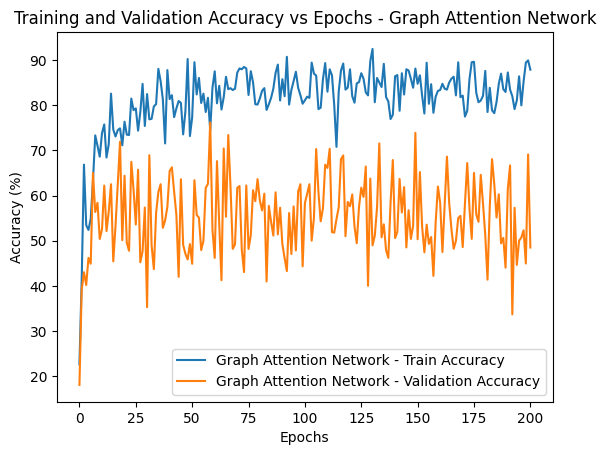

In [9]:
import matplotlib.pyplot as plt

# ... (previous code remains unchanged)

def train_and_plot(model, data, epochs, model_name):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer

    model.train()
    
    train_accuracies = []  # Store training accuracies
    val_accuracies = []    # Store validation accuracies

    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for batch in train_loader:
            optimizer.zero_grad()
            
            _, out = model(batch.x, batch.edge_index)
            loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
            total_loss += loss
            acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
            loss.backward()
            optimizer.step()

            # Validation
            val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
            val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

        # Calculate and store training and validation accuracies
        train_accuracies.append(acc/len(train_loader)*100)
        val_accuracies.append(val_acc/len(train_loader)*100)

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'{model_name} - Epoch {epoch:>3} | Train Loss: {total_loss/len(train_loader):.3f} '
                  f'| Train Acc: {train_accuracies[-1]:>6.2f}% | Val Loss: '
                  f'{val_loss/len(train_loader):.2f} | Val Acc: '
                  f'{val_accuracies[-1]:.2f}%')
    
    # Plotting
    plt.plot(range(epochs+1), train_accuracies, label=f'{model_name} - Train Accuracy')
    plt.plot(range(epochs+1), val_accuracies, label=f'{model_name} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training and Validation Accuracy vs Epochs - {model_name}')
    plt.legend()
    plt.show()

# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes).to(device)
print(graphsage)

# Train GraphSAGE
train_and_plot(graphsage, dataset, 200, 'GraphSAGE')

# Create GAT
gat = GAT().to(device)
print(gat)

# Train Graph Attention Network
train_and_plot(gat, dataset, 200, 'Graph Attention Network')

# ... (rest of the code remains unchanged)
